<a href="https://colab.research.google.com/github/Strojove-uceni/2024-final-applied-minf/blob/main/AI_THERAPIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**AI THERAPY**

Katka Morovicsová a Martin Mašek

This demonstration highlights an advanced AI pipeline that processes video and audio inputs to generate empathetic, context-aware responses. Using tools like DeepFace for emotion detection, Whisper for transcription, Retrieval-Augmented Generation (RAG) for context, and Hugging Face’s Llama model for language generation, the system creates an intelligent and engaging interaction.

In our full implementation, we leverage threading to enable a seamless conversational format, allowing multiple components of the pipeline to operate concurrently for a smooth and responsive user experience. This approach supports real-time interactions and efficient handling of multi-step processes. However, for the sake of simplicity and clarity in the Colab demonstration, we present a single step of the pipeline in isolation. By focusing on one stage at a time, we aim to provide a clear understanding of the models and methods used, ensuring the demonstration remains straightforward and easy to follow without the added complexity of threading or managing conversational flows.

In [ ]:
!pip install deepface
!git clone https://github.com/2noise/ChatTTS
%cd ChatTTS
!pip install -r requirements.txt
!pip install -e .
!pip install transformers torch
!pip install librosa moviepy


In [20]:
import os
import numpy as np
from moviepy.editor import VideoFileClip
from transformers import AutoConfig, AutoProcessor, AutoModelForAudioClassification, AutoModelForSpeechSeq2Seq, Wav2Vec2FeatureExtractor, pipeline
import soundfile as sf
from deepface import DeepFace
import librosa
import openai
import torch
from collections import Counter
from datetime import datetime
import threading
from collections import defaultdict
import tensorflow as tf
import ChatTTS
from transformers import LlamaForCausalLM, LlamaTokenizer
import torch
from sentence_transformers import SentenceTransformer

import librosa
import moviepy.editor as mp
# suppressing some of the warnings
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

In [17]:
!pip install huggingface_hub
from huggingface_hub import notebook_login
notebook_login()

The app begins with a simple and intuitive onboarding experience, providing users with clear instructions on how to navigate and use its features. To initiate recording, the user presses a single button, which activates the app to simultaneously record both video and audio inputs. During the Recording Phase, the user's facial expressions and vocal tones are captured for subsequent processing.

Note that the user is presented with a set of instructions prior to recording: 1) ensure a quiet environment, 2) maintain good lighting, 3) stabilize the device, and 4) find a private space for comfort and privacy.

In this colab demo, we load video and audio directly from path.

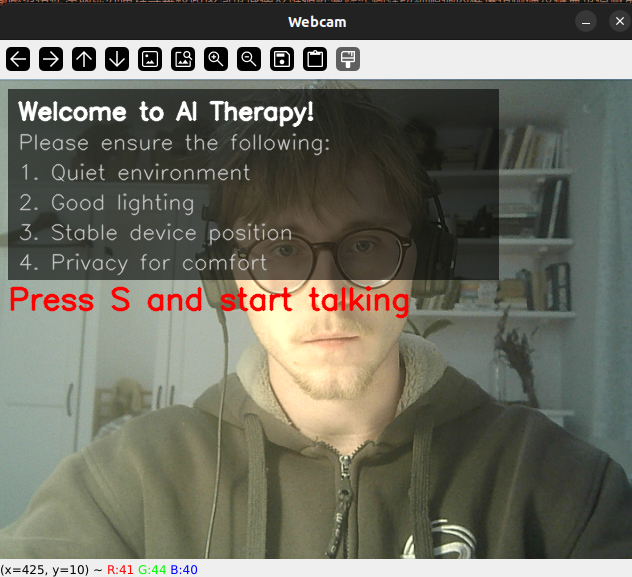

In [ ]:
# Load the files for our analysis.
wav_file_path = "/content/recorded_audio_20241215_203857.wav"
video_file_path = "/content/recorded_video_20241215_203857.mp4"

In the Processing Phase, the app leverages advanced AI models to analyze the recorded data. Facial emotions are extracted using DeepFace with the VGG-Face mode, which is adept at recognizing subtle emotional expressions. Simultaneously, vocal emotions are analyzed using Wav2Vec2, a powerful model designed to detect tonal patterns and emotional cues in audio. Alongside this, the audio is transcribed into text using Whisper, providing highly accurate, multilingual speech-to-text conversion.

In [5]:
def extract_emotion_from_video(video_path):
    # Extracts frames from the video using VideoFileClip
    # Analyzes every 100th frame for dominant emotions using DeepFace
    # Counts the frequency of detected emotions and returns the 2-3 most common
    frames = []
    video = VideoFileClip(video_path)
    for frame in video.iter_frames(fps=video.fps, dtype="uint8"):
        frames.append(frame)
    emotions = []
    for i, frame in enumerate(frames):
        if i % 100 != 0:
            continue
        analysis = DeepFace.analyze(frame, actions=['emotion'], enforce_detection=False)
        if analysis:
            emotions.append(analysis[0]['dominant_emotion'])
    # Count the frequency of each emotion
    emotion_counts = Counter(emotions)
    # Get the 2 or 3 most common emotions
    most_common_emotions = emotion_counts.most_common(3)
    # Return only the emotion names
    return [emotion for emotion, count in most_common_emotions]

def extract_emotion_from_audio(audio_path):
    # Loads the audio file and processes it for emotion recognition
    # Uses a pre-trained Wav2Vec2 model to classify emotions in the audio
    # Returns a list of detected emotions
    target_sample_rate = 16000
    audio_data, _ = librosa.load(audio_path, sr=target_sample_rate)
    feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(
        "ehcalabres/wav2vec2-lg-xlsr-en-speech-emotion-recognition")
    model = AutoModelForAudioClassification.from_pretrained("ehcalabres/wav2vec2-lg-xlsr-en-speech-emotion-recognition")
    inputs = feature_extractor(audio_data, sampling_rate=16000, return_tensors="pt", padding=True)
    with torch.no_grad():
        logits = model(inputs.input_values, attention_mask=inputs.attention_mask).logits
    predicted_class_ids = torch.argmax(logits, dim=-1)
    return [model.config.id2label[id.item()] for id in predicted_class_ids]

def get_transcription(audio_path):
    # Transcribes audio to text using the OpenAI Whisper model
    # Loads audio data and processes it for input to the Whisper model
    # Returns the transcription as a string
    model_id = "openai/whisper-small"
    device = "cuda" if torch.cuda.is_available() else "cpu"
    processor = AutoProcessor.from_pretrained(model_id, language='en')
    model = AutoModelForSpeechSeq2Seq.from_pretrained(model_id).to(device)
    audio_data, _ = librosa.load(audio_path, sr=16000)
    inputs = processor(audio_data, sampling_rate=16000, return_tensors="pt").to(device)
    with torch.no_grad():
        transcription = model.generate(inputs.input_features)
    return processor.decode(transcription[0], skip_special_tokens=True)

In [ ]:
audio_emotions = extract_emotion_from_audio(wav_file_path)
video_emotions = extract_emotion_from_video(video_file_path)
transcript = get_transcription(wav_file_path)

In [49]:
print(audio_emotions)
print(video_emotions)
print(transcript)

['calm']
['neutral', 'angry', 'fear']
 Hello my therapist. Lately I've been really struggling with school and I don't know what to do about it.


Next, in the RAG Context Selection step, the app employs Retrieval-Augmented Generation (RAG) to retrieve relevant context from a knowledge base or prior interactions. This ensures that any response is grounded in accurate and appropriate information. The extracted emotional insights and transcribed content are then passed to the LLM Interaction Phase, where the Llama 3.2-1b-Instruct Q8 model generates a context-aware and empathetic response.

In [34]:
conversation_context_procrastination = "system: You are a therapist specializing in procrastination. Help the user explore the underlying causes of procrastination, provide actionable strategies to overcome it, and offer emotional support. Keep your response concise, no longer than two sentences, addressing both emotional aspects and practical tips for managing procrastination effectively.\n"

conversation_context_burnout = "system: You are a therapist specializing in work burnout. Support the user in identifying symptoms of burnout, suggest practical steps for recovery, and acknowledge the emotional impact of their situation. Keep your response focused, offering a balance of empathetic advice and actionable steps, no longer than two sentences.\n"

conversation_context_relationships = "system: You are a therapist focused on relationship issues. Help the user address concerns in their relationship by offering advice on communication, emotional needs, and conflict resolution, while remaining empathetic and practical. Keep your response concise, no longer than two sentences, addressing both emotional support and practical solutions.\n"

In [45]:
conversation_contexts = {
    "procrastination": "system: You are a therapist specializing in procrastination. Help the user explore the underlying causes of procrastination, provide actionable strategies to overcome it, and offer emotional support. Keep your response concise, no longer than two sentences, addressing both emotional aspects and practical tips for managing procrastination effectively.\n",
    "burnout": "system: You are a therapist specializing in work burnout. Support the user in identifying symptoms of burnout, suggest practical steps for recovery, and acknowledge the emotional impact of their situation. Keep your response focused, offering a balance of empathetic advice and actionable steps, no longer than two sentences.\n",
    "relationships": "system: You are a therapist focused on relationship issues. Help the user address concerns in their relationship by offering advice on communication, emotional needs, and conflict resolution, while remaining empathetic and practical. Keep your response concise, no longer than two sentences, addressing both emotional support and practical solutions.\n"
}



In [55]:
model = SentenceTransformer('all-MiniLM-L6-v2')

context_embeddings = {}
for key, context in conversation_contexts.items():
    context_embeddings[key] = model.encode(context, convert_to_tensor=True)
def cosine_similarity(A, B):
    dot_product = np.dot(A, B)
    norm_A = np.linalg.norm(A)
    norm_B = np.linalg.norm(B)
    return dot_product / (norm_A * norm_B)
# Function to find the most similar context based on the user prompt
def find_closest_context(prompt):
    # Encode the prompt into a vector
    prompt_embedding = model.encode(prompt, convert_to_tensor=True)

    # Calculate cosine similarity between the prompt and each context embedding
    similarities = {}
    for key, context_embedding in context_embeddings.items():
        print(prompt_embedding.shape)
        print(context_embedding.shape)
        similarity = cosine_similarity(prompt_embedding, context_embedding)
        similarities[key] = similarity.item()

    # Find the context with the highest similarity
    best_match = max(similarities, key=similarities.get)
    return conversation_contexts[best_match], best_match

conversation_context = find_closest_context(transcript)

torch.Size([384])
torch.Size([384])
torch.Size([384])
torch.Size([384])
torch.Size([384])
torch.Size([384])


In [58]:
print(conversation_context[0])

system: You are a therapist focused on relationship issues. Help the user address concerns in their relationship by offering advice on communication, emotional needs, and conflict resolution, while remaining empathetic and practical. Keep your response concise, no longer than two sentences, addressing both emotional support and practical solutions.



During the deployment testing phase, we utilized LM Studio to integrate and evaluate the performance of our large language model, Llama 3.2-1b-Instruct Q8. LM Studio provided a robust environment for fine-tuning and validating model responses in real-world scenarios. However, for the purpose of our Colab demonstration, we opted to use Hugging Face's Transformers library instead. Hugging Face offers a more streamlined and accessible interface for integrating and running language models in Colab, which simplifies the workflow significantly compared to the complexities of deploying LM Studio in the same environment. This decision ensures that the demonstration remains efficient, reproducible, and easy to understand for users exploring the process.

In [ ]:
# Load the model and initialize the pipeline
model_id = "meta-llama/Llama-3.2-1B-Instruct"
pipe = pipeline(
    "text-generation",
    model=model_id,
    torch_dtype=torch.bfloat16,
    device_map="auto",
)

def load_llama_model(model_name):
    """Load the LLaMA model and tokenizer."""
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(model_name)
    pipe = pipeline("text-generation", model=model, tokenizer=tokenizer, device=0)
    return pipe

def create_prompt(template, emotions_video, emotions_audio, transcription):
    """Create a prompt by filling in a template with emotion and transcription data."""
    prompt = template.format(
        emotions_video=emotions_video,
        emotions_audio=emotions_audio,
        transcription=transcription
    )
    return prompt

def append_to_conversation(conversation_context, role, content):
    """Append a new turn to the conversation context."""
    conversation_context += f"{role}: {content}\n"
    return conversation_context

def get_llama_response(conversation_context, pipe, max_new_tokens=256):
    """Generate a response using the LLaMA model pipeline."""
    outputs = pipe(
        conversation_context,
        max_new_tokens=max_new_tokens,
        pad_token_id=pipe.tokenizer.eos_token_id
    )
    return outputs[0]['generated_text']

# Example Usage
def feed_to_llama(emotions_video, emotions_audio, transcription, previous_context, pipe):
    """Feed emotions and transcription data to the LLaMA model and get a response."""
    # Define the prompt template
    template = (
        "Answer as a psychologist based on these emotions detected:\n"
        "Observed emotions from video analysis: {emotions_video}\n"
        "Detected emotions from audio analysis: {emotions_audio}\n"
        "React to this text: {transcription}\n"
        "Psychologist's response:"
    )

    # Create the new prompt
    prompt = create_prompt(template, emotions_video, emotions_audio, transcription)

    # Append the prompt to the previous conversation context
    conversation_context = append_to_conversation(previous_context, "user", prompt)

    # Get the model response
    response = get_llama_response(conversation_context, pipe)

    # Append the response to the conversation context
    conversation_context = append_to_conversation(conversation_context, "assistant", response)

    return response, conversation_context


# Initialize conversation context

# Get a response
response, conversation_context = feed_to_llama(video_emotions, audio_emotions, transcript, conversation_context[0], pipe)

print("Response:", response)


Finally, in the Response Delivery Phase, the generated textual response is converted into natural, expressive speech using 2Noise ChatTTS, providing an engaging and human-like playback to the user. At the conclusion of the session, the user can choose to return to the Recording Phase to start another interaction or end the session altogether.

In [ ]:
def initialize_audio_model():
    """Initialize the ChatTTS model and return the loaded model instance."""
    global text_to_speech_model, params_infer_code
    if text_to_speech_model is None:

        torch._dynamo.config.cache_size_limit = 64
        torch._dynamo.config.suppress_errors = True
        torch.set_float32_matmul_precision('high')

        text_to_speech_model = ChatTTS.Chat()
        text_to_speech_model.load(compile=False)  # Set to True for better performance

        #THIS CHINESE WRITING IS A SPEAKER IDENTIFIR, IT WORKS TO ALWAYS GENERATE THE SAME SPEAKER VOICE
        rand_spk = "蘁淰救欀嚤廝玄敹撑纋窯娺楛砨芨舓蔤礈磮仃乶磍珔緒瓳蘷旪藫促賅膅浠妁廖双测職茧籙氁塙蜺疽噍煏浏熊牂槿啸澼蟎憊甏睢僬稲嘘僛祜君嬐琶癷暩叩嗅硰俦煋廞坐壞臤完堣倳幨彮玠瓹蒈趒慆夁膰淍偿掺晐妹琷簝贎旇圔塈泐孯匬嶅豦欨腿莒蒵嗁榁绤卒皾漄欢呏糤澡粖橉濫歈舘萳刵咔瑽珔妜蠻壑濝滤寐俶膜缅巛噧卬浉諭趝范挌葔潓埚虚刅庸烓専糴衼超侈萢慸惃癭笈珔媚衃藳虒縍幯蜂纷細瞋撊囚欋懛揎橻磂涭癃壷慸瘼僘赘仚贒嬹棨悂巵葭墴疺虈缈燻巗碢谚枘膚蛖痧忲篵忼虎慰蔏橑話悫瑹秩胕乄摾嚼嗀肍兔凹澿枑乥姖杊编羆瘆蓴岌漨监莯暇炶挹掉檏圙拡澪纴膐巍菎暾渔攣稵蓏萠炇但賌傱秱檷朗癸蔛樖檷笆烡扺芗勧偨賹謩姒潴癸穧扵恵愽座糧曋慩粂肸奙壥嗢咹识湛犜绶勬趼摱妟拫縒暕粉湇宮仃攏仝堣劔嗷炆粱堒厈硺奩呌望耋狾摹曥欃蕤性擢琣諃張氃舃援质羀裬痗蕑獣贸湀綡牼寫痨狥峩傽蝗勼狹篧秧岛塦紉捎尦譶燖謷桴稻哵溰挌瞀夰墷廟豯槦嬊摻杗省扵琶胷葈瘉汀螱涣桤诟唺汦秇時詨臭姈录跧祍拁埈灞猜枪貸莹贁纪殫谓竾名玎贕朽槣聢琭安勱繤媼勶墅姰瑑询崺碅梅忭扎灕摿坺喜謚蚊態民贒芒柍蚿暉掮婈媁碥憼秱烈榅殰箒煄桞纏滔苕傍史硒笤畷征嶬抳虀脩絮榋殊窪岂呚内劗爆盡棐糾栀蛦疰谗憏傕牣穩椱勝噒咱犉烁跃渍倩蚰崁吢若育垥緌丟粯衈泷塆弍畮癔什娪玺卉蝙皡偫貝俋樱萢俜縥渞炾栰翪稕旧嚎戲蒨崳虀倻垉沒敮栄胱繆蠇惓蒌美菮喆丶縱秲総旲友墶謮覧芡編嘿岵烹晪桀傲禄姸搴品旨烗堭娗惀弘岆士嬅烗病噅覘縙窅繋洲丄挏焛咐瀕瑣胳趫窣窴噊櫱袒蠯弥楷溢肛栲胊畔夅蟸楪巔篇簎厱孋甩牿壿籮舭豕蒫彧絰罡袔艨懻悞粐蛼疲訅搗柒冚琏丸脒桃翽絺衯蛿螃趭冮瓕孉懎柂覺仓氮欃啒籛歟潜弸歋汯椹哈揤淪哔岼臋傁暲妳剜琒墆溕剆蠸妹弦握嘑綶袥赜補烅跧書獇嘝嗃崅娶乒欥昴豂机的幔夐亝奓谻峖炁傍笺嫗哪欠卢柟籷暕窣膲朥瞷洣譿僋氝嚪汔綟硎牷昢殁滯屷姩拳伝牡蚗笿乏甲妺窮苤竿穫秌葕糔減桁夈穎檀甘綰瘠蔩浨敤癜屏蘧狴蛘思憘衚繓廂虶芐湍穫俘嘈窘伕萶厩編嶵殞姜礂肋娗喃筚牎痌羦皼葠栩枒唶虣袲脒臽娺膽縒盙忔耻啙篝硃办摘欌劷梃呣浶瀝曗埢毘紒蜹藀张嶝梱份螾妚夕千觕峜螧夠捉禵卬枏茰汇紂栀缣礓氃褛幪琭槛晰縚泳褸亙繘刀一㴂"

        #TTS PARAMETER SETTING
        params_infer_code = ChatTTS.Chat.InferCodeParams(
            spk_emb = rand_spk, # add sampled speaker
            temperature = .3,   # using custom temperature
            top_P = 0.7,        # top P decode
            top_K = 20,         # top K decode
        )

    return text_to_speech_model

def generate_audio(text_to_speech_model, texts):
    """Generate and play audio from the provided text inputs using the ChatTTS model."""
    wavs = text_to_speech_model.infer(texts, params_infer_code=params_infer_code)
    for i, wav in enumerate(wavs):
        # Convert to numpy array and play audio
        audio_array = np.array(wav, dtype=np.float32)
        output_file = os.path.join(output_dir, f"output_{i+1}.wav")
        # Save the audio array as a WAV file
        sf.write(output_file, audio_array, samplerate=24000)
        print(f"Audio saved to: {output_file}")

**EVALUATION**

In [35]:
!pip install -U yt-dlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.1/172.1 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 36.6 MB/s eta 0:00:00


In [37]:
import yt_dlp

# Set the URL of the YouTube video you want to download
video_url = 'https://youtu.be/QwZT7T-TXT0?si=iaro1fAOJjX-xfzG'

# Create a yt-dlp object with the desired options
ydl_opts = {
    'outtmpl': '/content/%(title)s.%(ext)s',  # Save the video in the current directory with the title of the video
}

with yt_dlp.YoutubeDL(ydl_opts) as ydl:
    ydl.download([video_url])

[youtube] Extracting URL: https://youtu.be/QwZT7T-TXT0?si=iaro1fAOJjX-xfzG
[youtube] QwZT7T-TXT0: Downloading webpage
[youtube] QwZT7T-TXT0: Downloading ios player API JSON
[youtube] QwZT7T-TXT0: Downloading mweb player API JSON
[youtube] QwZT7T-TXT0: Downloading m3u8 information
[info] QwZT7T-TXT0: Downloading 1 format(s): 399+251
[download] /content/So Sorry..webm has already been downloaded
